<h1>Clustering</h1>

In [33]:
!pip install pyod

In [34]:
!pip install kneed

In [35]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, KFold, GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pyod.models.knn import KNN
from kneed import KneeLocator

In [36]:
data = pd.read_csv('/content/drive/MyDrive/spotify top tracks/tracks_with_binary_target.csv')
data.drop(['is_dance_pop'], axis=1, inplace=True)
data.set_index(['title'], inplace=True)
data.head()

,artist,top genre,followers,artist_popularity,year,tempo,energy,danceability,loudness,liveness,valence,duration,acousticness,speechiness,track_popularity
title,,,,,,,,,,,,,,,
"Hey, Soul Sister",Train,neo mellow,3.618665,78.0,2010,97.0,89.0,67.0,-4.0,8.0,80.0,217.0,19.0,4.0,83
Love The Way You Lie,Eminem,detroit hip hop,42.795820,95.0,2010,87.0,93.0,75.0,-5.0,52.0,64.0,263.0,24.0,23.0,82
TiK ToK,Kesha,dance pop,6.235482,82.0,2010,120.0,84.0,76.0,-3.0,29.0,71.0,200.0,10.0,14.0,80
Bad Romance,Lady Gaga,dance pop,16.716518,90.0,2010,119.0,92.0,70.0,-4.0,8.0,71.0,295.0,0.0,4.0,79
Just the Way You Are,Bruno Mars,pop,29.381079,93.0,2010,109.0,84.0,64.0,-5.0,9.0,43.0,221.0,2.0,4.0,78


In [37]:
genres = data['top genre'].values

Since all of the clustering algorithms can work only with numeric data, I am not going to use the categorical attributes for clustering.

In [38]:
data.drop(['artist', 'top genre', 'year'], axis=1, inplace=True)

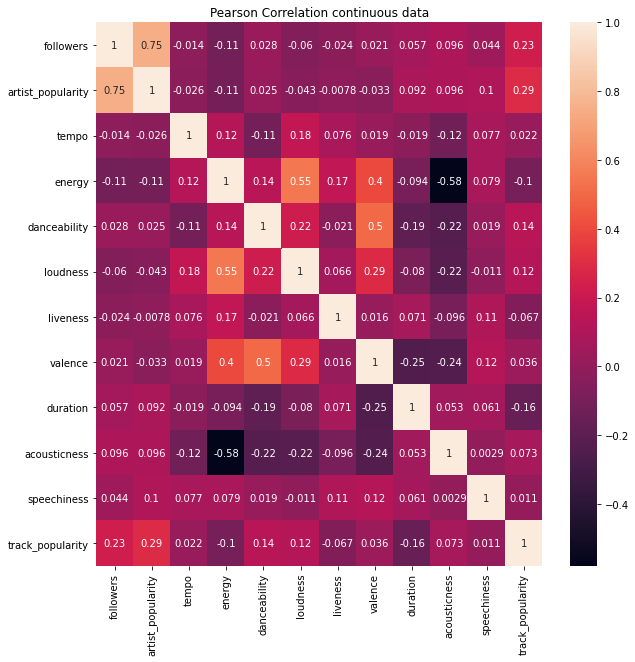

In [39]:
plt.figure(figsize=(10,10))
sns.heatmap(data.corr(), annot=True)
plt.title('Pearson Correlation continuous data')
plt.show()

The variables followers and artist_popularity have a high positive correlation of 0.75. They carry a lot of the same information, maybe we should drop one to not bias the clustering toward that attribute.

In [40]:
data.drop(['followers'], axis=1, inplace=True)

In [41]:
scaler = StandardScaler()
data[data.columns] = scaler.fit_transform(data)
data

,artist_popularity,tempo,energy,danceability,loudness,liveness,valence,duration,acousticness,speechiness,track_popularity
title,,,,,,,,,,,
"Hey, Soul Sister",-0.875133,-0.872087,1.171065,0.153473,0.588284,-0.735360,1.226763,-0.166653,0.177696,-0.588078,1.023778
Love The Way You Lie,1.259999,-1.275210,1.414670,0.748947,0.227002,2.526820,0.513485,1.159147,0.410982,1.805096,0.956284
TiK ToK,-0.372749,0.055096,0.866559,0.823381,0.949566,0.821590,0.825544,-0.656622,-0.242220,0.671487,0.821297
Bad Romance,0.632019,0.014784,1.353769,0.376776,0.588284,-0.735360,0.825544,2.081443,-0.708793,-0.588078,0.753803
Just the Way You Are,1.008807,-0.388339,0.866559,-0.069829,0.227002,-0.661219,-0.422693,-0.051366,-0.615478,-0.588078,0.686309
...,...,...,...,...,...,...,...,...,...,...,...
Lucid Dreams,1.636787,-1.400058,-0.802133,-1.030030,-0.578657,1.192292,-1.367787,0.491521,0.919547,1.427226,1.361248
Stuck with U (with Justin Bieber),1.511191,2.424050,-1.508586,-0.389896,-0.372004,1.503682,0.054312,0.164279,0.331665,-0.565406,1.226260
If the World Was Ending - feat. Julia Michaels,-0.875133,-1.726668,-1.368514,-1.379871,-1.610478,-0.520352,0.352997,-0.406248,3.331730,0.532935,1.226260


Since the clustering results with K-means are sensitive to outliers and some variants of hierarchical clustering also, I am going to use KNN based multivariate outlier detector to remove these outliers.

In [42]:
knn_outlier_detector = KNN(contamination=0.05, n_neighbors=4, method='mean')

In [43]:
outliers = knn_outlier_detector.fit_predict(data)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)


In [44]:
data['Outlier'] = outliers

The data points labeled with 0 are not outliers, the ones labeled with 1 were detected as outliers. I am going to retain only the non-outliers.

In [45]:
data_no_outliers = data[data['Outlier']==0]
data_no_outliers.drop(['Outlier'], axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Perform dimensionality reduction to plot the data in 2D.

In [46]:
pca = PCA(n_components=2)
decomposed_features = pca.fit_transform(data_no_outliers)

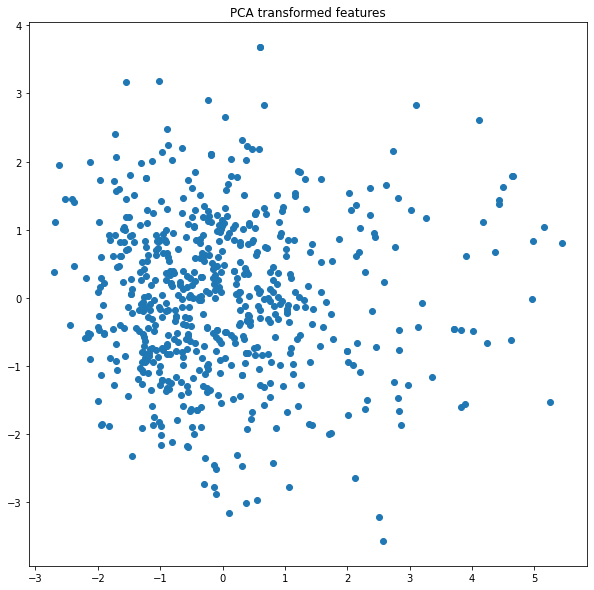

In [47]:
plt.figure(figsize=(10,10))
plt.scatter(decomposed_features[:, 0], decomposed_features[:, 1])
plt.title('PCA transformed features')
plt.show()

Some density differences are visible in the data. Maybe DBSCAN would be able to find some meaningfull clusters. K-means will probably not find a good clustering.

<h3>1. K-mean clustering</h3>

In [48]:
def plot_clusters(data, labels, title, centroids=None):
  plt.figure(figsize=(7,5))
  sns.scatterplot(x=data[:,0], y=data[:,1], c=labels, ax=plt.gca())
  if centroids is not None:
    sns.scatterplot(x=centroids[:,0], y=centroids[:,1], marker="x", color="r", s=200, ax=plt.gca())
  plt.title(title)
  plt.show()

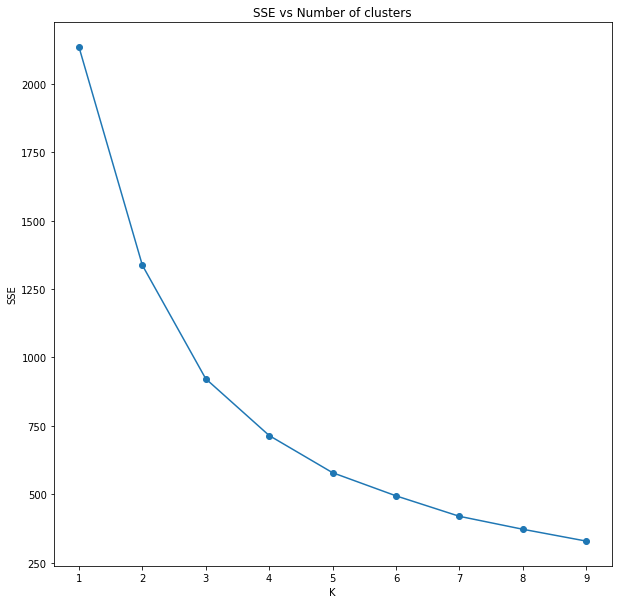

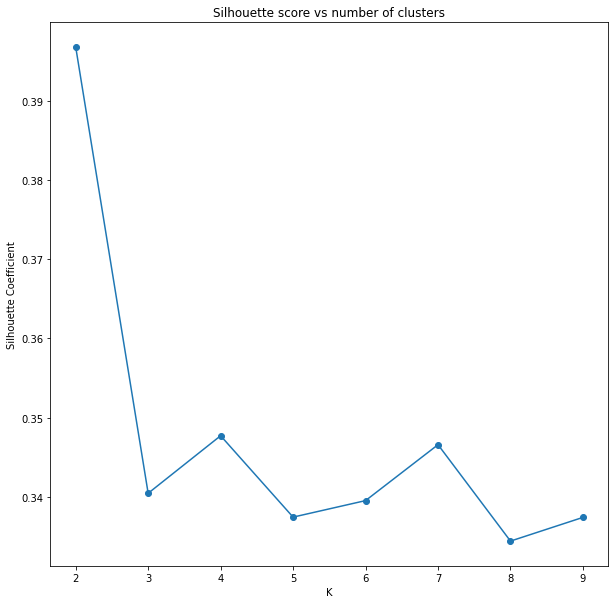

In [49]:
num_clusters = range(1, 10)
SSE = []
silhouette_coefficients = []
for k in num_clusters:
  kmeans = KMeans(n_clusters=k, max_iter=150, random_state=0)
  kmeans.fit(decomposed_features)
  SSE.append(kmeans.inertia_)
  if k != 1:
    score = silhouette_score(decomposed_features, kmeans.labels_)
    silhouette_coefficients.append(score)

plt.figure(figsize=(10,10))
plt.plot(range(1, 10), SSE, marker='o');
plt.xlabel('K'); 
plt.ylabel('SSE');
plt.title('SSE vs Number of clusters')
plt.show()

plt.figure(figsize=(10,10))
plt.plot(range(2, 10), silhouette_coefficients, marker='o')
plt.xlabel("K")
plt.ylabel("Silhouette Coefficient")
plt.title('Silhouette score vs number of clusters')
plt.show()

In [50]:
kl = KneeLocator(range(1, 10), SSE, curve="convex", direction="decreasing")
kl.elbow

3

The sharp lowering of the sum of squared errors is at three clusters, after that the lowering is insignificant at each step. The chosen number of clusters is 3.

Let's visualize the clusters. K-means has a tendention for globular, equally sized clusters.

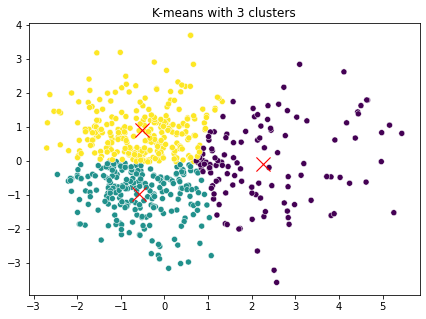

In [51]:
kmeans = KMeans(n_clusters=kl.elbow, max_iter=150, random_state=0)
kmeans.fit(decomposed_features)
plot_clusters(decomposed_features, kmeans.labels_, "K-means with " +str(kl.elbow)+ " clusters", kmeans.cluster_centers_)

In [52]:
silhouette_coefficients[1]

0.3404294216582033

The value of the silhouette coefficient for this clustering is almost 0.36 which implies that the clusters are not well separated, which is visible from the plot.

<h3>2. Hierarchical Clustering</h3>

In [53]:
results = []
for num_clust in range(2, 16):
  for link in ["ward", "complete", "average", "single"]:
    node = {}
    agglomerative = AgglomerativeClustering(n_clusters=num_clust, linkage=link)
    agglomerative.fit(decomposed_features)
    node['num_clusters'] = num_clust
    node['linkage'] = link
    node['silhouette score'] = silhouette_score(decomposed_features, agglomerative.labels_)
    node['variance ratio'] = calinski_harabasz_score(decomposed_features, agglomerative.labels_)
    results.append(node)
results = pd.DataFrame(results)

In [54]:
results

,num_clusters,linkage,silhouette score,variance ratio
0,2,ward,0.445456,309.280340
1,2,complete,0.354559,318.981636
2,2,average,0.490974,303.444009
3,2,single,0.557221,8.799830
4,3,ward,0.293882,343.106779
5,3,complete,0.295656,213.166150
6,3,average,0.399916,167.359142
7,3,single,0.488135,7.973328
8,4,ward,0.317134,371.872676
9,4,complete,0.269708,260.442169


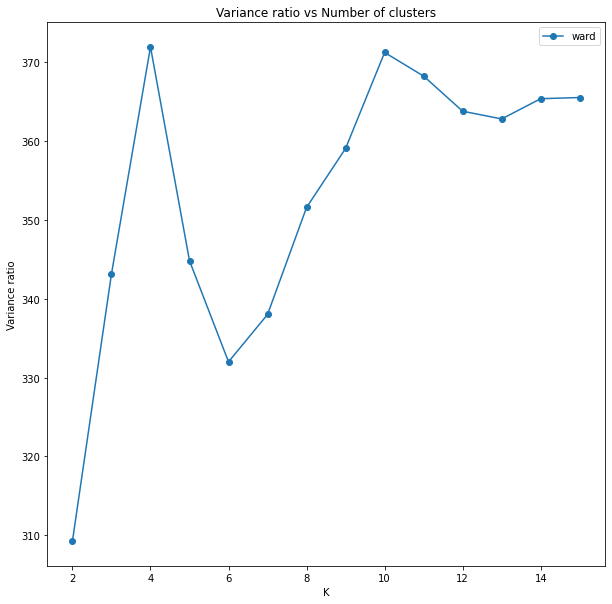

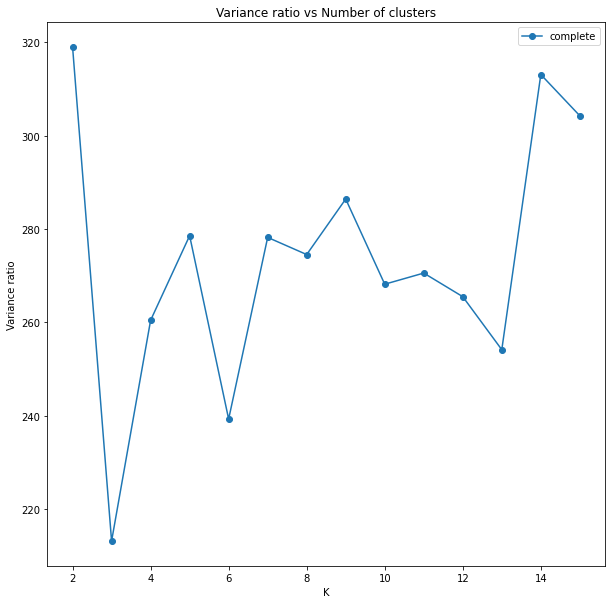

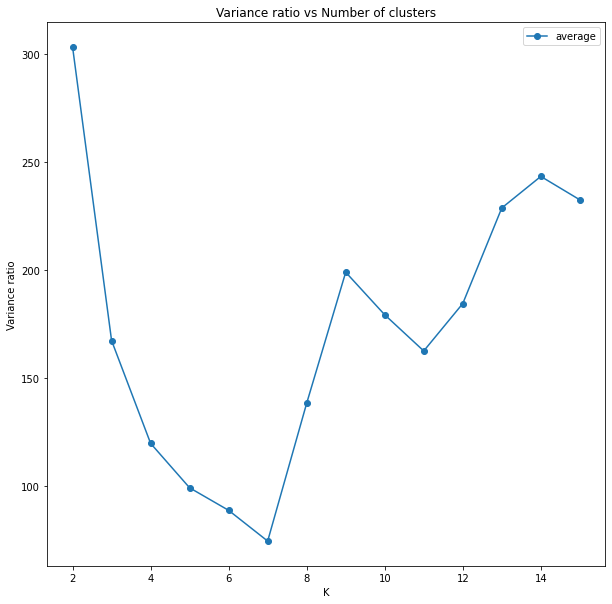

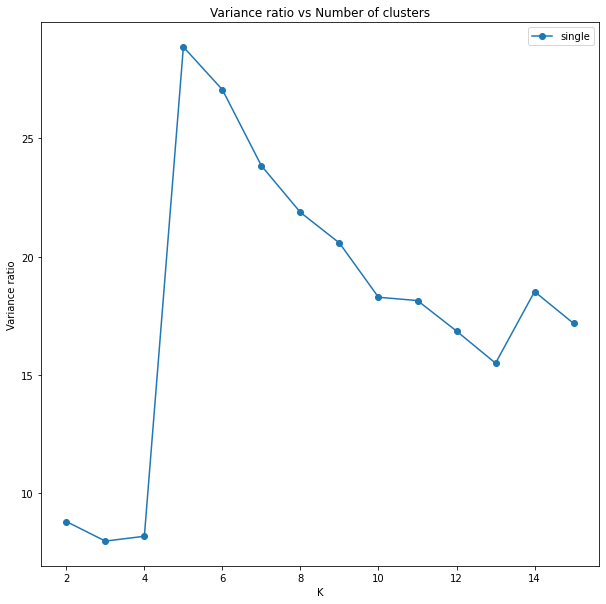

In [55]:
for link in ["ward", "complete", "average", "single"]:
  plt.figure(figsize=(10,10))
  plt.plot(range(2,16), results[results['linkage']==link]['variance ratio'], marker='o', label=link);
  plt.xlabel('K'); 
  plt.ylabel('Variance ratio');
  plt.title('Variance ratio vs Number of clusters')
  plt.legend()
  plt.show()

Single link produces the lowest variance ratio values whereas ward's method produces the largest values. But the variance ratio is higher for convex clusters such as those generated for K-meas, and ward's method is the hierarchical equivalent to K-means.

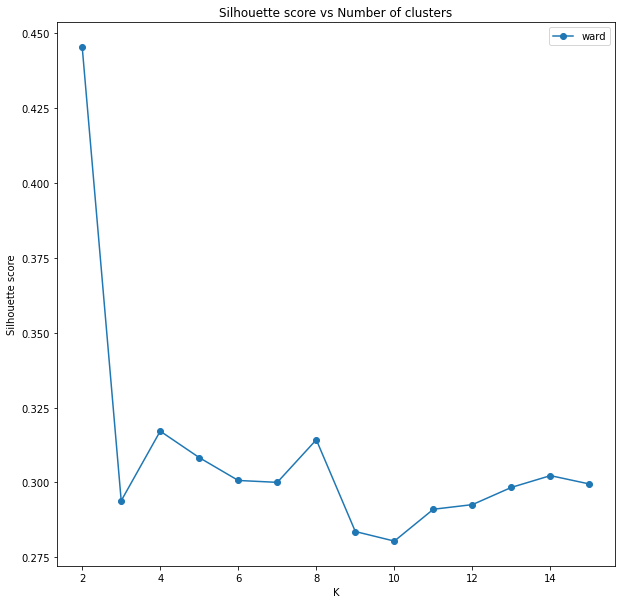

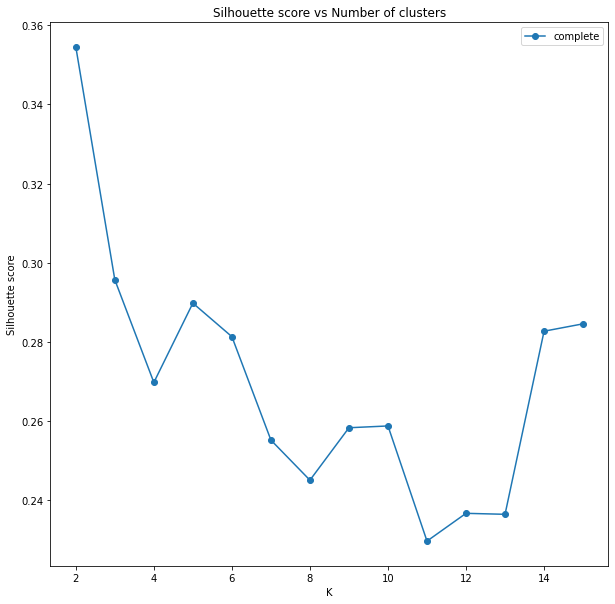

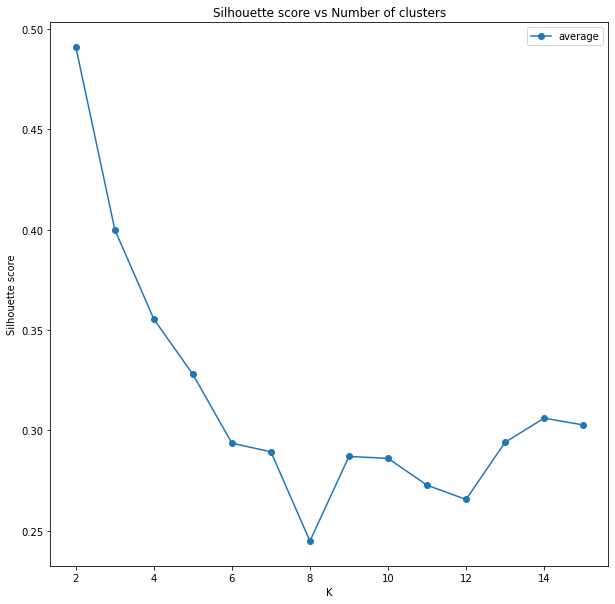

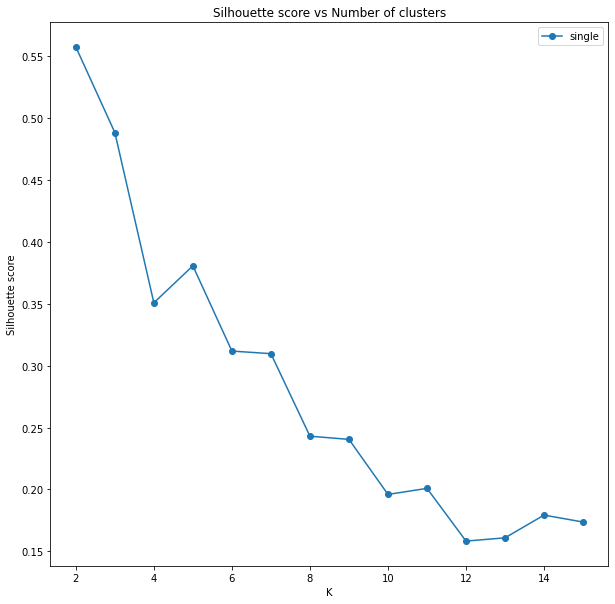

In [56]:
for link in ["ward", "complete", "average", "single"]:
  plt.figure(figsize=(10,10))
  plt.plot(range(2,16), results[results['linkage']==link]['silhouette score'], marker='o', label=link);
  plt.xlabel('K'); 
  plt.ylabel('Silhouette score');
  plt.title('Silhouette score vs Number of clusters')
  plt.legend()
  plt.show()

Since the single link clustering is continguity based, then the final 2 clusters may consist of num_datapoints - 1 and 1. That's why for these values, the variance ratio is low but the silhouette coefficient is high. To balance this, I am going to scale the variance ratio for it to have a value between 0 and 1 and use the maximum of the average of variance ratio and silhouette score as the best clustering.

In [57]:
results['variance ratio'] = results['variance ratio'] / np.max(results['variance ratio'])
results['combined metric'] = results['variance ratio']*0.5 + results['silhouette score']*0.5
best = results[results['combined metric'] == np.max(results['combined metric'])]

In [113]:
best['num_clusters'].values[0], best['linkage'].values[0]

(4, 'ward')

The best values are 4 clusters and ward's method.

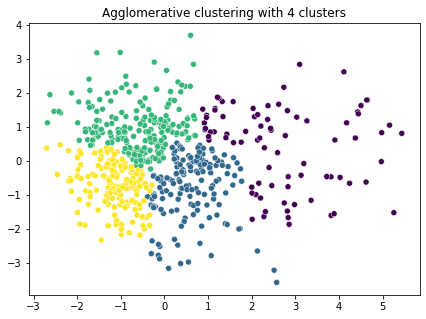

In [86]:
agglomerative = AgglomerativeClustering(n_clusters=best['num_clusters'].values[0], linkage=best['linkage'].values[0])
agglomerative.fit(decomposed_features)
plot_clusters(decomposed_features, agglomerative.labels_, "Agglomerative clustering with " + str(best['num_clusters'].values[0]) + " clusters")

Let's visualize the hierarchical grouping of the first 50 songs.

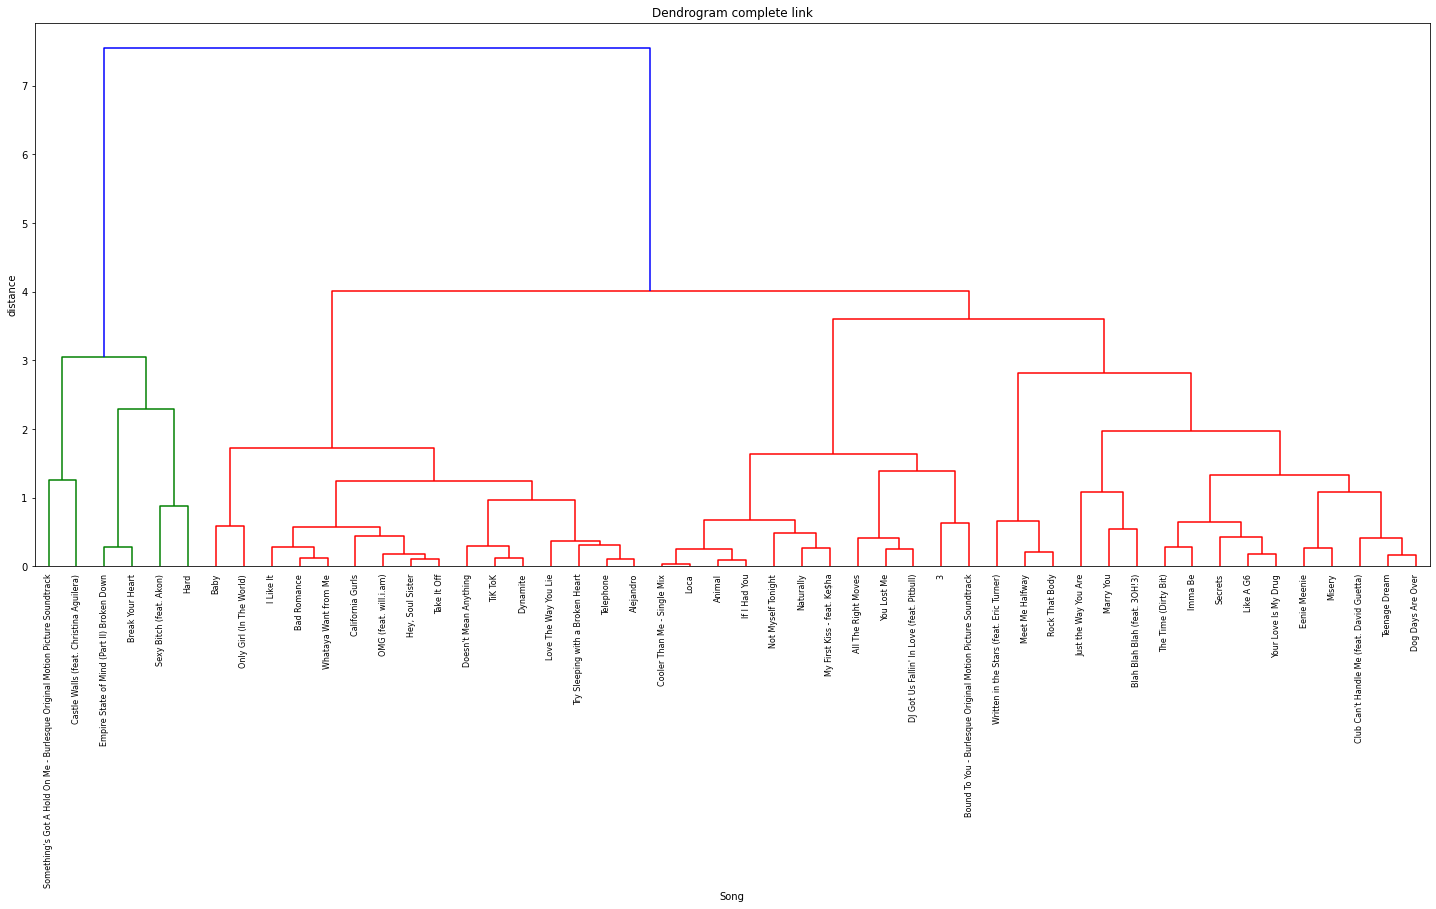

In [59]:
Z = linkage(decomposed_features[:50], 'complete')
fig = plt.figure(figsize=(25, 10))
plt.title('Dendrogram complete link')
plt.xlabel('Song')
plt.xticks(ticks = range(0, 10), labels=data.index[:50].tolist(), rotation=90)
plt.ylabel('distance')
dendrogram(Z, leaf_rotation=90., leaf_font_size=8., ax=plt.gca(), labels=data.index[:50].tolist());
plt.show()

<h3>3. DBSCAN</h3>

In [60]:
from sklearn.neighbors import NearestNeighbors

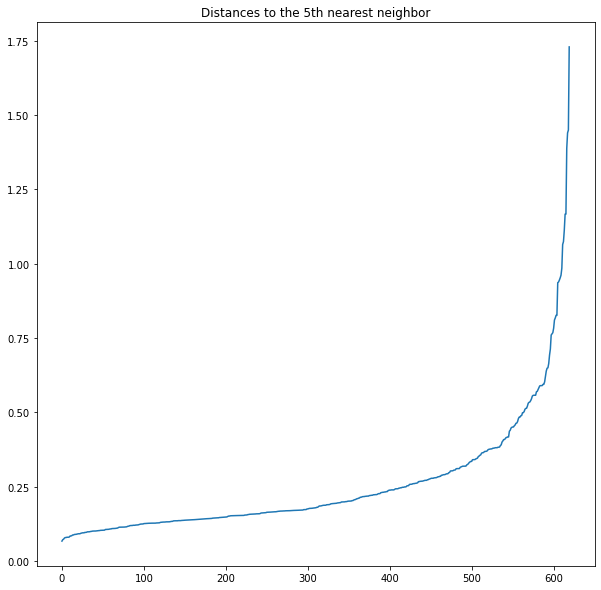

In [106]:
distances = []
neigh = NearestNeighbors(n_neighbors=5)
nbrs = neigh.fit(decomposed_features)
distances, indices = nbrs.kneighbors(decomposed_features)
distances = np.sort(distances, axis=0)
distances = distances[:, 4]

plt.figure(figsize=(10,10))
plt.plot(distances);
plt.title('Distances to the 5th nearest neighbor')
plt.show()

The value of epsilon for 5 min points is around 0.6 so that's the value 
I'm going to select.

In [107]:
kl = KneeLocator(range(1, len(data_no_outliers)+1), distances, curve="convex", direction="increasing")

In [108]:
kl.elbow

587

In [109]:
eps = distances[kl.elbow]
eps

0.5940945930699122

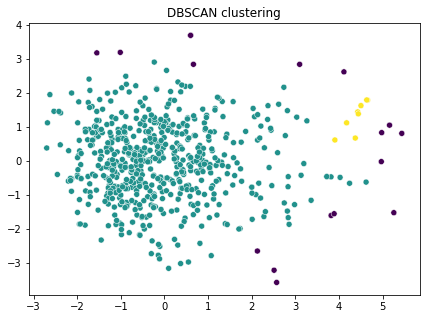

In [110]:
dbscan = DBSCAN(eps=eps, min_samples=5).fit(decomposed_features)
plot_clusters(decomposed_features, dbscan.labels_, 'DBSCAN clustering')

In [111]:
silhouette_score(decomposed_features, dbscan.labels_)

0.48646821617498615

In [112]:
calinski_harabasz_score(decomposed_features, dbscan.labels_)

53.85525628339105

It seems like DBSCAN is detecting one cluster in the dense region and the other points that are clustered together look more like outliers, but this is due to the lower density in those regions. It does not work quite well.